In [13]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [14]:
def parse_filename(filename):
    fn_re = "pool-(?P<pool>.+)_expr-(?P<expr>.+)_sw-(?P<sw>\d+)"
    fn_re = fn_re + "_es-(?P<es>\d+)_qd-(?P<qd>\d+)_pg-(?P<pg>\d+)"
    fn_re = fn_re + "_rt-(?P<rt>\d+)_if-(?P<if>.+)\.log"
    fn_re = re.compile(fn_re)
    match = fn_re.match(os.path.basename(filename))
    assert match
    return match

In [15]:
def short_ename(ename):
    mapping = {
        'bytestream_n1_write': 'n1wr',
        'bytestream_n1_append': 'n1ap',
        'bytestream_11': '11wr',
        'map_n1': 'n1kv',
        'map_11': '11kv'
    }
    return mapping[ename]

In [16]:
def read_trace(filename, trimFrontSec=30, trimBackSec=30):
    ### read up raw throughput file
    trace = pd.read_table(filename, sep=" ",
        header=None, names=("completed", "throughput"))
    
    ### shift timeseries to have zero start time
    trace.completed = pd.to_datetime(trace.completed, unit="ns")
    trace.completed = trace.completed - min(trace.completed)
    trace.completed = trace.completed / pd.Timedelta(seconds=1)
    
    ### trim front and back of trace
    trace = trace[(trace.completed > trimFrontSec) & (trace.completed <
        max(trace.completed) - trimBackSec)]
    trace.completed = trace.completed - min(trace.completed)
    
    ### order like a time series by the completion time of the I/O
    trace.sort_values(by='completed', ascending=True, inplace=True)
    return trace

In [17]:
def plot_throughput_trace(trace, md, ax):
    trace.throughput = pd.rolling_mean(trace.throughput, window=5, min_periods=1)
    label = md.group('expr')
    label = short_ename(label)
    ax.plot(trace.completed, trace.throughput, label=label)
    #ax.set_title('Single OSD Throughput (Jewel 2016)')
    ax.set_ylabel('Appends per Second per OSD')
    ax.set_xlabel('Time (Sec)')

In [18]:
def plot_traces(traces, fn, finish=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for filename in traces:
        trace_data = read_trace(filename)
        md = parse_filename(filename)
        plot_throughput_trace(trace_data, md, ax)
    if finish:
        lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(fn + '.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))
    else:
        return ax

The next graph was run on CloudLab using a strategy in which after each experiment ran pool being used in Ceph was deleted, and a new pool was created. The performance we see here is a little less 'clean' than it was when we completely wiped Ceph after each experiment. Since the 1:1 experiments were run first, and they may have created 10's of millions of objects, then who knows what adverse affects that may have on other experiments.

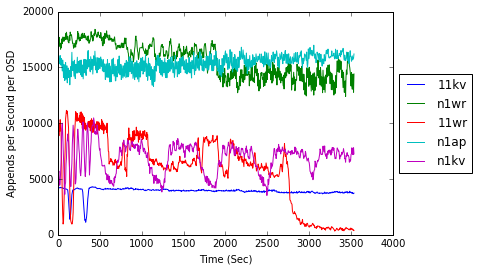

In [19]:
traces = glob.glob('results.pd.librados_sweep.node0.04-19-2016_13-44-49/*.log')
plot_traces(list(traces), 'output.pool.reset')

The next graph is the same as the previous graph except in between each run we do a soft reset of ceph (as opposed to just deleting and recreating the target pool). A soft reset is basically a complete from scratch setup of the cluster, except we skip uninstalling and reinstalling any software.

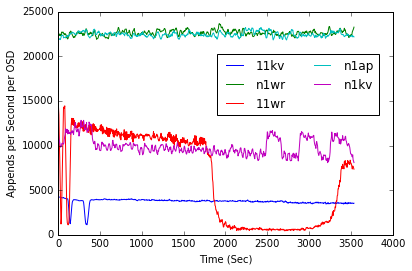

In [26]:
traces = glob.glob('results.pd.librados_sweep.node0.04-20-2016_13-39-44/*.log')
ax = plot_traces(list(traces), 'output.soft.reset', finish=False)
lgd = ax.legend(loc='best', ncol=2, bbox_to_anchor=(0.48,0.52), bbox_transform=plt.gcf().transFigure)
plt.savefig('jewel_ssd.png', dpi=300, bbox_inches='tight')

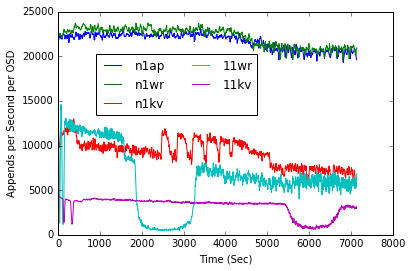

In [21]:
traces = glob.glob('results.pd.librados_sweep.node0.04-22-2016_19-51-05/*.log')
ax = plot_traces(list(traces), 'output.soft.reset.2hr', finish=False)
lgd = ax.legend(loc='best', ncol=2, bbox_to_anchor=(0.60,0.52), bbox_transform=plt.gcf().transFigure)
plt.savefig('output.soft.reset.2hr.png', dpi=300, bbox_inches='tight')

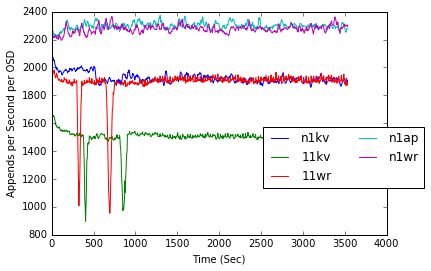

In [25]:
traces = glob.glob('results.pd.vanilla_firefly.node0.05-14-2016_20-05-15/*.log')
ax = plot_traces(list(traces), 'output.soft.reset.2hr', finish=False)
#ax.set_ylim(ymin=0)
lgd = ax.legend(loc='best', ncol=2, bbox_to_anchor=(0.60,0.52), bbox_transform=plt.gcf().transFigure)
plt.savefig('firefly_ssd.png', dpi=300, bbox_inches='tight')